In [ ]:
## Drive
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


# Dataset and Code

In [ ]:
## dataset
!cp -r /gdrive/MyDrive/saliency_data/ .
! unzip -q 'saliency_data/*.zip' 
! mkdir maps
! mv train maps/
! mv val maps/

In [ ]:
## Weight
!cp /gdrive/MyDrive/basnet.pth .

In [ ]:
## Code
!git clone https://github.com/ckhui/SaliencySegmentationNet.git

Cloning into 'SaliencySegmentationNet'...
remote: Enumerating objects: 30, done.
remote: Counting objects: 100% (30/30), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 30 (delta 7), reused 30 (delta 7), pack-reused 0
Unpacking objects: 100% (30/30), done.


# Tensor Board

In [ ]:
%load_ext tensorboard
%tensorboard --logdir /gdrive/MyDrive/logs/

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


<IPython.core.display.Javascript object>

In [ ]:
# from tensorboard import notebook
# notebook.list()
# # notebook.display(port=6006, height=1000)

# Lib and Folder Setup 

In [ ]:
!mkdir /gdrive/MyDrive/weights/
!mkdir /gdrive/MyDrive/logs/

mkdir: cannot create directory ‘/gdrive/MyDrive/weights/’: File exists


In [ ]:
!pip install --upgrade albumentations

     |████████████████████████████████| 98 kB 5.2 MB/s 
     |████████████████████████████████| 37.1 MB 47 kB/s 
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


# Inference

In [ ]:
import sys
sys.path.insert(0,'/content/SaliencySegmentationNet/')

In [ ]:
|# ## GETnerate init_weight
import torch
from model.net import SSNet
model = SSNet(3)
# model_dir = './basnet.pth'
# model_dir = "/gdrive/MyDrive/weights/" ## infer
# model.load_state_dict(torch.load(model_dir), strict=False)
# # model_dir = "../weights/"
# model_dir = './'
# torch.save(model.state_dict(), model_dir + "SSNET_init.pth")

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


KeyboardInterrupt: ignored

In [ ]:
## Training
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


from model.net import SSNet
from dataloader import SaliconCoCoDataset
from model.loss import multi_seg_loss_fusion, multi_bce_loss_fusion

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
BATCH_SIZE = 1

dataset_folder = "./"
val_txt_path = "/content/SaliencySegmentationNet/dataset/val_list.txt"
val_img_list = np.loadtxt(val_txt_path, dtype=str)
val_dataset = SaliconCoCoDataset(dataset_folder, val_img_list)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=False)

model = SSNet(3, pretrain_resnet=False)
model_dir = "/gdrive/MyDrive/weights/SSNET_10.pth"
model.load_state_dict(torch.load(model_dir), strict=False)
model.to(DEVICE)

SSNet(
  (inconv): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (inbn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (inrelu): ReLU(inplace=True)
  (encoder1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [ ]:
with torch.no_grad():
    model.eval()
    for data in tqdm(val_loader):
        input_img, sal_map, seg_map = data['image'], data['saliency'], data['mask']
        input_img, sal_map, seg_map = input_img.to(DEVICE), sal_map.squeeze(1).to(DEVICE), seg_map.to(DEVICE)

        seg_out, sal_out = model(input_img)
        break

  0%|          | 0/5000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:3613: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)
  0%|          | 0/5000 [00:00<?, ?it/s]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


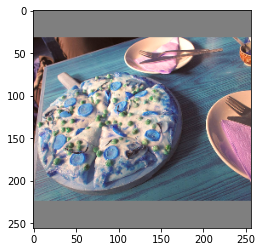

In [ ]:
plt.imshow(input_img[0].permute((1,2,0)).cpu().detach().numpy()[:,:,::-1]*0.225+0.5)

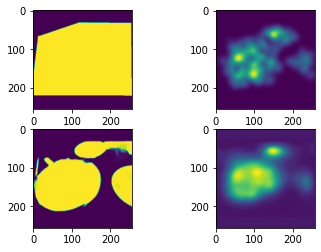

In [ ]:
from matplotlib import pyplot as plt
plt.subplot(2,2,1)
plt.imshow(seg_map[0,0].cpu().detach().numpy())
plt.subplot(2,2,2)
plt.imshow(sal_map[0].cpu().detach().numpy())


plt.subplot(2,2,3)
plt.imshow(seg_out[0][0,0].cpu().detach().numpy())
plt.subplot(2,2,4)
plt.imshow(1 - sal_out[0][0,0].cpu().detach().numpy())

In [ ]:
gt = sal_map[0].cpu().detach().numpy()
out = 1 - sal_out[0][0,0].cpu().detach().numpy()

(array([34580.,  9770.,  5408.,  2708.,  2146.,  1795.,  1896.,  3486.,
         2807.,   940.]),
 array([0.3967049 , 0.399698  , 0.4026911 , 0.40568417, 0.40867728,
        0.41167036, 0.41466343, 0.41765654, 0.42064962, 0.42364272,
        0.4266358 ], dtype=float32),
 <a list of 10 Patch objects>)

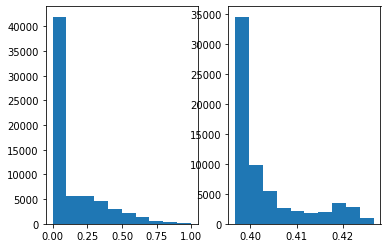

In [ ]:
plt.subplot(1,2,1)
plt.hist(gt.flatten())
plt.subplot(1,2,2)
plt.hist(out.flatten())

# **Training**

In [ ]:
import sys
sys.path.insert(0,'/content/SaliencySegmentationNet/')

In [ ]:
## Training
import numpy as np
import torch
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter


from model.net import SSNet
from dataloader import SaliconCoCoDataset
from model.loss import multi_seg_loss_fusion, multi_bce_loss_fusion

## Param
BATCH_SIZE = 10
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
EPOCH = 200
EVAL_EPOCH = 2
# FREEZE_SEG = True
FREEZE_SEG = False
LOG_INTERVAL = 250
TENSORBOARD_DIR = '/gdrive/MyDrive/logs/'

LR = 1e-4
WEIGHT_DECAY = 0.01
SCHEDULER_STEP_SIZE = 10 * 300
SCHEDULER_GAMMA = 0.1

SAVE_MODEL_DIR = "/gdrive/MyDrive/weights/"

# Tensorboard
writer = SummaryWriter(log_dir=TENSORBOARD_DIR)

## dataset 
dataset_folder = "./"
train_txt_path = "/content/SaliencySegmentationNet/dataset/train_list.txt"
train_img_list = np.loadtxt(train_txt_path, dtype=str)
train_dataset = SaliconCoCoDataset(dataset_folder, train_img_list)
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, drop_last=True)

val_txt_path = "/content/SaliencySegmentationNet/dataset/val_list.txt"
val_img_list = np.loadtxt(val_txt_path, dtype=str)[:2000]
val_dataset = SaliconCoCoDataset(dataset_folder, val_img_list)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, drop_last=False)
print(f"DATASET: {len(train_dataset)} Train {len(val_dataset)} Val")
    
## model
model = SSNet(3, False)
# model_dir = './SSNET_init.pth'
model_dir = "/gdrive/MyDrive/weights_ss/SSNET_best.pth"
model.load_state_dict(torch.load(model_dir), strict=False)
if FREEZE_SEG:
    for name, param in model.named_parameters():
        if "_sal" not in name:
            param.requires_grad = False
model.to(DEVICE)

## optimizer
optimizer = optim.Adam(model.parameters(), lr=LR, betas=(0.9, 0.999), eps=1e-08, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=SCHEDULER_STEP_SIZE, gamma=SCHEDULER_GAMMA)

## train loop
running_loss = 0.0
batch_count = 0
epoch_loss_sal = 0.0
epoch_loss_seg = 0.0
cum_loss_sal = 0.0
cum_loss_seg = 0.0
val_loss_sal = 0.0
val_loss_seg = 0.0

best_val = 999

for epoch in range(EPOCH):
    model.train()
    for data in tqdm(train_loader):
        batch_count += 1
        input_img, sal_map, seg_map = data['image'], data['saliency'], data['mask']
        input_img, sal_map, seg_map = input_img.to(DEVICE), sal_map.squeeze(1).to(DEVICE), seg_map.to(DEVICE)

        optimizer.zero_grad()
        seg_out, sal_out = model(input_img, segmentation=not FREEZE_SEG)
        last_sal_loss, sum_sal_loss = multi_seg_loss_fusion(sal_out[0], sal_out[1],sal_out[2],sal_out[3],sal_out[4],sal_out[5],sal_out[6], sal_map)
        loss = sum_sal_loss
        
        epoch_loss_sal += last_sal_loss.item() # Record
        cum_loss_sal += sum_sal_loss.item() # Record
        writer.add_scalar("Loss/sal", last_sal_loss.item(), batch_count)
        writer.add_scalar("Loss/sal_total", sum_sal_loss.item(), batch_count)
        
        if not FREEZE_SEG:
            last_seg_loss, sum_seg_loss = multi_bce_loss_fusion(seg_out[0], seg_out[1],seg_out[2],seg_out[3],seg_out[4],seg_out[5],seg_out[6], seg_map)
            loss += sum_seg_loss

            epoch_loss_seg += last_seg_loss.item() # Record
            cum_loss_seg += sum_seg_loss.item() # Record
            writer.add_scalar("Loss/seg", last_seg_loss.item(), batch_count)
            writer.add_scalar("Loss/seg_total", sum_seg_loss.item(), batch_count)
        
        del seg_out, sal_out, input_img, sal_map, seg_map

        loss.backward()
        optimizer.step()
        
        if batch_count % LOG_INTERVAL == 0:
            # print BATCHES Progress
            print(f"[BATCH {batch_count:5d}] sal_loss: {cum_loss_sal/LOG_INTERVAL} seg_loss: {cum_loss_seg/LOG_INTERVAL}")
            cum_loss_sal = 0.0
            cum_loss_seg = 0.0
            
    # print EPOCH Progress
    epoch_loss_sal = epoch_loss_sal/len(train_dataset)
    epoch_loss_seg = epoch_loss_seg/len(train_dataset)
    print(f"[EPOCH {epoch:5d}] sal_loss: {epoch_loss_sal} seg_loss: {epoch_loss_seg}")
    writer.add_scalar("Train/batch_sal", epoch_loss_sal, epoch)
    writer.add_scalar("Train/batch_seg", epoch_loss_seg, epoch)
    epoch_loss_sal = 0.0
    epoch_loss_seg = 0.0      
   
    if epoch % EVAL_EPOCH == 0:
        with torch.no_grad():
            model.eval()
            for data in tqdm(val_loader):
                input_img, sal_map, seg_map = data['image'], data['saliency'], data['mask']
                input_img, sal_map, seg_map = input_img.to(DEVICE), sal_map.squeeze(1).to(DEVICE), seg_map.to(DEVICE)

                seg_out, sal_out = model(input_img)
                last_sal_loss, _ = multi_seg_loss_fusion(sal_out[0], sal_out[1],sal_out[2],sal_out[3],sal_out[4],sal_out[5],sal_out[6], sal_map)
                last_seg_loss, _ = multi_bce_loss_fusion(seg_out[0], seg_out[1],seg_out[2],seg_out[3],seg_out[4],seg_out[5],seg_out[6], seg_map)
                val_loss_sal += last_sal_loss.item()
                val_loss_seg += last_seg_loss.item()

                del seg_out, sal_out, input_img, sal_map, seg_map

            val_loss_sal = val_loss_sal/len(train_dataset)
            val_loss_seg = val_loss_seg/len(train_dataset)
            total_loss = val_loss_sal + val_loss_seg
            print(f"[EVAL {epoch:5d}] sal_loss: {val_loss_sal} seg_loss: {val_loss_seg} total: {total_loss}")
            writer.add_scalar("Val/batch_sal", val_loss_sal, epoch)
            writer.add_scalar("Val/batch_seg", val_loss_seg, epoch)
            val_loss_sal = 0
            val_loss_seg = 0

            if epoch % 10 == 0:
                torch.save(model.state_dict(), SAVE_MODEL_DIR + f"SSNET_{epoch}.pth")
            if total_loss < best_val:
                best_val = total_loss
                torch.save(model.state_dict(), SAVE_MODEL_DIR + "SSNET_best.pth")
                print("\n=========SAVED BEST @", epoch, "===============")

DATASET: 10000 Train 2000 Val



  0%|          | 0/1000 [00:00<?, ?it/s]


RuntimeError: ignored

In [ ]:
while True:pass